In [1]:
from pathlib import Path
import os
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from concurrent.futures import ProcessPoolExecutor
import RNA, os, functools, itertools, pickle
from collections import defaultdict

cwd = Path(os.getcwd())
WORKING_DIR = cwd.parent
DATASET_DIR = WORKING_DIR.parent / "dataset"

np.random.seed(42)

In [10]:

# ------------------------------------------------------------------
# 1. I/O --------------------------------------------------------------------
files = {
    "pre":        cwd / "transcriptome/RNN_predictions.parquet",
    "post_soft":  cwd / "transcriptome/predictions_soft_mining.parquet",
    "post_hard":  cwd / "transcriptome/predictions_hard_mining.parquet",
}
tx = pd.read_csv(cwd / "transcriptome/gencode_customized.tsv", sep="\t")
tx["ids"] = tx.index
tx_dict = tx.groupby("gene_id")["ids"].apply(list).to_dict()

preds = {k: pd.read_parquet(p) for k, p in files.items()}


In [3]:
#we generate or load the unusable positions  in the transcriptome, which correspond to sequences long 51 already present in the training dataset
unusable_path = cwd / "transcriptome/unusable_sequences.pickle"

if unusable_path.exists():
    print(f"Loading existing unusable sequences from {unusable_path}")
    with open(unusable_path, "rb") as f:
        unusable_sequences = pickle.load(f)
else:
    print(f"File not found. Generating unusable sequences...")
    
    # Load the dataset and process sequences
    path_full_dataset = DATASET_DIR / "full_dataset_final_training.pickle"
    with open(path_full_dataset, "rb") as f:
        full_dataset = pickle.load(f)
    
    resized_sequences = []
    for key, value in full_dataset.items():
        for i in range(len(value)):
            seq = value[i]
            seq = seq[50:151-50]
            resized_sequences.append(seq)

    resized_sequences = set(resized_sequences)

    # Find unusable sequences
    unusable_sequences = defaultdict(list)
    for index, row in tx.iterrows():
        seq = row["sequence"]
        c_pos = np.where(np.array([x for x in seq]) == "C")[0]
        for pos in c_pos:
            cut_seq = seq[pos-25:pos+26]
            if cut_seq in resized_sequences:
                unusable_sequences[index].append(int(pos))
    unusable_sequences = dict(unusable_sequences)

    with open(unusable_path, "wb") as f:
        pickle.dump(unusable_sequences, f)
    
    print(f"Unusable sequences generated and saved to {unusable_path}")

unrolled_unusable_sequences = set()
for key, value in unusable_sequences.items():
    for pos in value:
        unrolled_unusable_sequences.add((key, pos))



# Check if each pair is in the set (faster than apply for large DataFrames)
for key, value in preds.items():
    # Create a list of tuples from the DataFrame columns
    tx_pos_pairs = list(zip(preds[key]['tx_idx'], preds[key]['center_pos']))
    preds[key]['is_unusable'] =  [pair in unrolled_unusable_sequences for pair in tx_pos_pairs]


Loading existing unusable sequences from /home/saitto/rna_modifications_project/codes/transcriptome_analysis/transcriptome/unusable_sequences.pickle


In [ ]:

# # ------------------------------------------------------------------
# # 2. helpers --------------------------------------------------------
# @functools.lru_cache(maxsize=None)
# def fold_one(seq, temp=37.0):
#     md = RNA.md();  md.temperature = temp
#     return RNA.fold_compound(seq, md).mfe()[0]         # keep dot-bracket only

# def calc_pairing(dot_brackets: list[str]) -> np.ndarray:
#     """percentage of paired positions"""
#     L = len(dot_brackets[0])
#     paired = np.zeros(L, dtype=int)
#     for s in dot_brackets:
#         paired += np.fromiter((c in '()' for c in s), dtype=int, count=L)
#     return paired / len(dot_brackets) * 100


In [2]:

# ------------------------------------------------------------------
# 3. params ---------------------------------------------------------
class_order  = ["prob0", "prob1", "prob2", "prob3", "prob4"]
model_order  = ["pre", "post_soft", "post_hard"]
nice_names   = dict(prob0="Negatives", prob1="Type I", prob2="Type II",
                    prob3="Type III", prob4="Type IV",
                    pre="Pre-trained", post_soft="Negative Mining (Light)", post_hard="Negative Mining (Heavy)")


ranges_map = {                    # tailor bands per (model, class)
    "pre": {
        "prob0": [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        "prob1": [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        "prob2": [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        "prob3": [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        "prob4": [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    },
    "post_soft": {
        "prob0": [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        "prob1": [0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 1.0],
        "prob2": [0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 1.0],
        "prob3": [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        "prob4": [0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 1.0],
    },
    "post_hard": {
        "prob0": [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        "prob1": [0.5, 0.55, 0.6, 0.7, 0.8, 1.0],
        "prob2": [0.5, 0.6, 0.7, 0.75, 0.8, 1.0],
        "prob3": [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        "prob4": [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    },
}

# window
LEN  = 41
KEEP = LEN // 2


In [ ]:

# # ------------------------------------------------------------------
# # 4. compute pairing ------------------------------------------------
# all_results = {m: {cls: [] for cls in class_order} for m in model_order}
# all_seqs = {m: {cls: [] for cls in class_order} for m in model_order}
# for model in model_order:
#     df = preds[model]
#     for cls in class_order:
#         bands = ranges_map[model][cls]
#         for lo, hi in zip(bands[:-1], bands[1:]):
#             mid = 0.5*(lo + hi)
#             subset = df[(df[cls] > lo) & (df[cls] < hi) & ~df['is_unusable']]
#             if subset.empty:
#                 continue
#             subset = subset.sample(min(len(subset), 10000), random_state=42)

#             # --- extract seq around centre ------------------------
#             seqs = []
#             for row in subset.itertuples():
#                 tx_idx, cpos = int(row.tx_idx), int(row.center_pos)
#                 seq = tx.iloc[tx_idx].sequence[cpos-KEEP : cpos+KEEP+1]
#                 if 'P' not in seq and len(seq) == LEN:
#                     seqs.append(seq)
#             if not seqs:          # nothing survived filters
#                 continue
#             #remove duplicates
#             seqs = list(set(seqs))
#             #add sequences to all_seqs
#             all_seqs[model][cls].append(seqs)
#             # --- fold in parallel ---------------------------------
#             with ProcessPoolExecutor(max_workers=8) as pool:
#                 structs = list(pool.map(fold_one, seqs))

#             y = calc_pairing(structs)
#             lab = f"{lo:.2f}-{hi:.2f}"
#             all_results[model][cls].append((lab, y, mid))



# path = cwd / "analysis_results"
# path.mkdir(exist_ok=True)
# with open(path / "pairing_results.pickle", "wb") as f:
#     pickle.dump((all_results, all_seqs), f)


In [3]:
#open the pickle file
path = cwd / "analysis_results"
with open(path / "pairing_results.pickle", "rb") as f:
    all_results, all_seqs = pickle.load(f)

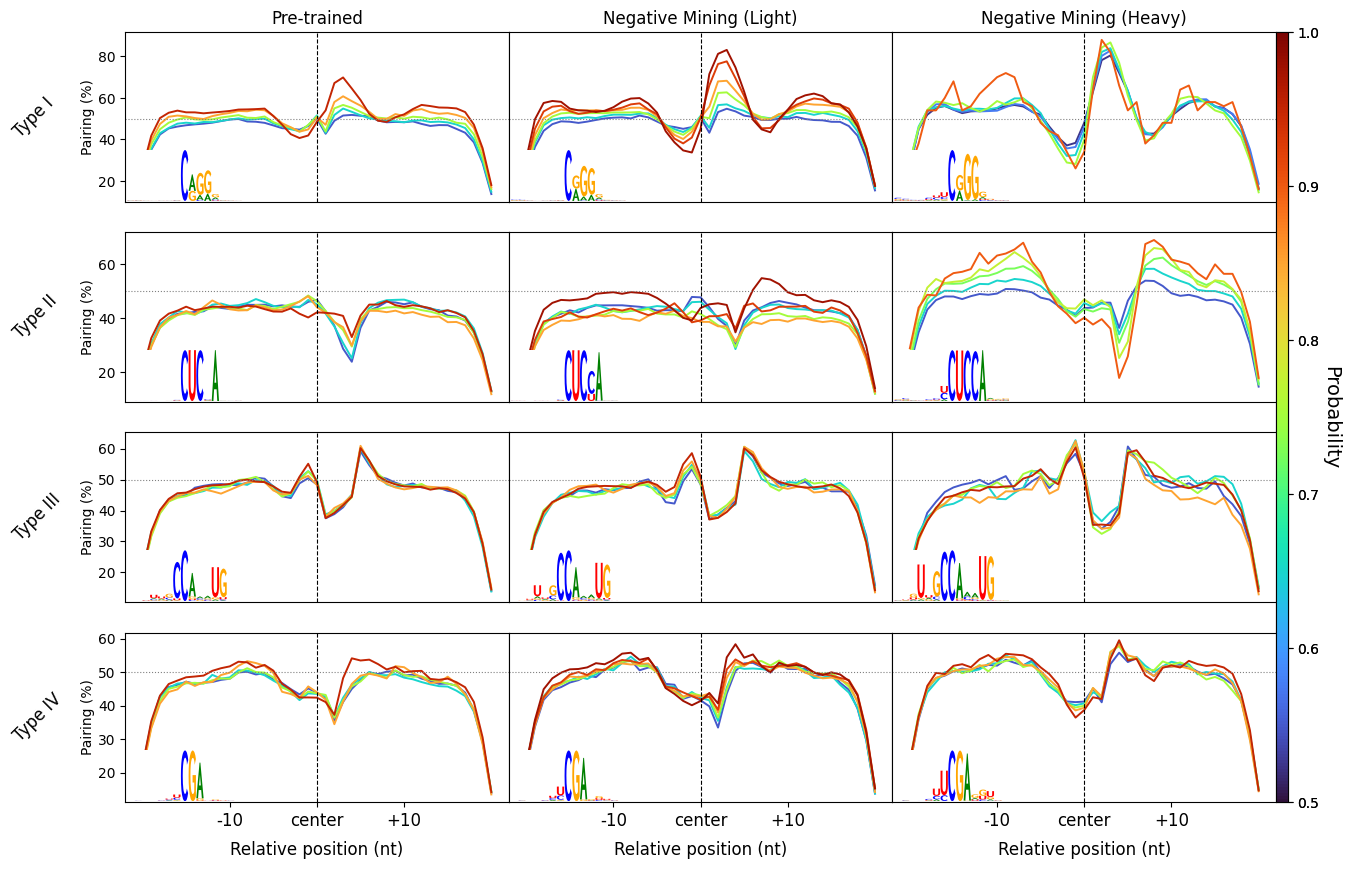

In [4]:
import itertools
import logomaker

class_order  = ["prob1", "prob2", "prob3", "prob4"]

# one-hot map (define once)
map_dict = {
    "A": [1,0,0,0],
    "C": [0,1,0,0],
    "G": [0,0,1,0],
    "T": [0,0,0,1],
}

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm      as cm
from matplotlib.gridspec import GridSpec

# 1) compute per-row y-limits (as before)
row_limits = []
for cls in class_order:
    all_vals = []
    for mdl in model_order:
        for _, vec, _ in all_results[mdl][cls]:
            all_vals.append(vec)
    arr = np.concatenate(all_vals)
    mn, mx = arr.min(), arr.max()
    pad = 0.05 * (mx - mn)
    row_limits.append((mn - pad, mx + pad))

# 2) figure + GridSpec with zero wspace
fig = plt.figure(figsize=(15, 10))
gs  = GridSpec(
    nrows=len(class_order),
    ncols=len(model_order)+1,
    width_ratios=[1, 1, 1, 0.03],
    wspace=0.0,   # ⬅︎ no horizontal gap
    hspace=0.18
)

# 3) colourbar on the right
cmap = plt.get_cmap("turbo") 
norm = mcolors.Normalize(vmin=0.5, vmax=1.0)
sm   = cm.ScalarMappable(norm=norm, cmap=cmap)
cax  = fig.add_subplot(gs[:, -1])
cb   = fig.colorbar(sm, cax=cax, orientation='vertical')
cb.set_label("Probability", rotation=270, labelpad=15, fontsize=14)

# 4) plot grid + inset logos
x = np.arange(LEN)
for r, cls in enumerate(class_order):
    ymin, ymax = row_limits[r]
    for c, mdl in enumerate(model_order):
        ax = fig.add_subplot(gs[r, c])
        # 4a) draw pairing curves
        for lab, vec, mid in all_results[mdl][cls]:
            ax.plot(x, vec, lw=1.4, color=cmap(norm(mid)))
        ax.axvline(KEEP, ls="--", lw=0.8, c="black")
        ax.axhline(50,  ls=":",  lw=0.8, c="grey")
        ax.set_ylim(ymin, ymax)

        # 4b) y-axis on first column only
        if c == 0:
            ax.set_ylabel("Pairing (%)", fontsize=10, labelpad=2)
            ax.text(-0.30, 0.5, nice_names[cls],
                    transform=ax.transAxes,
                    fontsize=12, rotation=45,
                    va="center")
        else:
            ax.set_yticks([])

        # 4c) top titles
        if r == 0:
            ax.set_title(nice_names[mdl], pad=6, fontsize=12)

        # 4d) bottom x-ticks
        if r < len(class_order)-1:
            ax.set_xticks([])
        else:
            positions = [KEEP-10, KEEP, KEEP+10]
            labels    = ["-10", "center", "+10"]
            ax.set_xticks(positions)
            ax.set_xticklabels(labels, fontsize=12)
            ax.set_xlabel("Relative position (nt)", labelpad=8, fontsize=12)

        # ─── 4e) inset logo ──────────────────────────────────────
        # flatten all bands' seqs into one list
        flat = list(itertools.chain.from_iterable(all_seqs[mdl][cls]))
        # extract central 15-mers
        mini = [s[KEEP-7:KEEP+8] for s in flat if len(s)==LEN]
        if mini:
            # build PWM
            arr = np.array([list(seq) for seq in mini])
            oh  = np.array([[map_dict.get(ch, [0,0,0,0]) for ch in row] for row in arr])
            pwm = oh.sum(axis=0)
            pwm = pwm / pwm.sum(axis=1, keepdims=True)

            info_df = logomaker.transform_matrix(
                pd.DataFrame(pwm, columns=["A","C","G","U"]),
                from_type="probability", to_type="information"
            )

            # inset axes: [x0, y0, width, height] in relative coords
            inset = ax.inset_axes([0.005, 0.005, 0.30, 0.30]) # means [left, bottom, width, height]
            logomaker.Logo(info_df, ax=inset, font_name="inconsolata")
            # clean up inset
            inset.set_xticks([]); inset.set_yticks([])
            inset.spines[:].set_visible(False)

# colorbar on the right (as before)
cax = fig.add_subplot(gs[:, -1])
fig.colorbar(sm, cax=cax, orientation="vertical")

# plt.savefig(cwd / "analysis_results/pairing_results.pdf", bbox_inches="tight")
# plt.savefig(cwd / "analysis_results/pairing_results.eps", bbox_inches="tight")


In [20]:
preds_now = preds["post_hard"]
preds_1 = preds_now.copy()
preds_2 = preds_now.copy()

In [37]:
preds_1.sort_values(by=["prob1"], ascending=False, inplace=True)
preds_2.sort_values(by=["prob2"], ascending=False, inplace=True)

In [81]:
seqs = []
LEN = 51
KEEP = LEN // 2
for i in range(200):
    tx_idx = int(preds_2.iloc[i].tx_idx)
    cpos = int(preds_2.iloc[i].center_pos)
    seq = tx.iloc[tx_idx].sequence[cpos-KEEP : cpos+KEEP+1]
    seq = seq.replace("T", "U")
    if 'P' not in seq and len(seq) == LEN:
        seqs.append(seq)
seqs = list(set(seqs))
seqs = [x for x in seqs if "P" not in x]

In [82]:
res = {}
for seq in seqs:
    fc  = RNA.fold_compound(seq)
    (ss, mfe) = fc.mfe()
    ssc = list(ss)
    ssc[KEEP] = "C"
    ssc = "".join(ssc)
    res[seq] = (ss, ssc)

In [ ]:
# .((((((.....))))))
# CGGGGCGUCCCCUGCCCU

#GGCGCUGCUCUCCAAGGCGCC
#((((((.........))))))


In [ ]:
dict_motifs_filtered = all_seqs["post_hard"]
dict_motifs_filtered.pop("prob0")

In [115]:
pwm_positives_dict = {}
for motif_id, motifs_list_of_list in dict_motifs_filtered.items():
    motifs = [y for x in motifs_list_of_list for y in x]
    motifs = [x[13:41-13] for x in motifs]  # extract central 15-mers
    pwm_positives = np.zeros((4, 15))
    motifs_array = np.array([[y for y in x] for x in motifs])
    for i, letter in enumerate(["A", "C", "G", "T"]):
        pwm_positives[i] = np.sum(motifs_array == letter, axis=0) / motifs_array.shape[0]

    pwm_positives_dict[motif_id] = pwm_positives

In [ ]:
mapping_pos = {"Type I": [7,12],
                "Type II": [6,12],
                "Type III": [3,13],
                "Type IV": [5,13]}
prob_types = {"Type I": "prob1",
                "Type II": "prob2",
                "Type III": "prob3",
                "Type IV": "prob4"}
types = ["Type I", "Type II", "Type III", "Type IV"]
for type_ in types:
    
    pos_0 = mapping_pos[type_][0]
    pos_1 = mapping_pos[type_][1]
    fig, ax = plt.subplots(figsize=(pos_1-pos_0, 3), sharex=False, sharey=False, tight_layout = True)
    pwm_now = pwm_positives_dict[prob_types[type_]]
    pwm = np.array(pwm_now).T[pos_0:pos_1] + 1e-9
    pwm = pwm / np.sum(pwm, axis=-1).reshape(-1, 1)
    pwm = pd.DataFrame(pwm, columns=["A","C","G","U"])
    info_df = logomaker.transform_matrix(pwm,
                                        from_type='probability',
                                        to_type='information')
            
    logo = logomaker.Logo(info_df, ax=ax, font_name='inconsolata',)
    ax.set_xticks([])
    ax.set_yticks([])
    #remove frame
    # ax.spines['top'].set_visible(False)
    # ax.spines['right'].set_visible(False)
    # ax.spines['left'].set_visible(False)
    # ax.spines['bottom'].set_visible(False)
    #increase spline width and height
    ax.spines['top'].set_linewidth(2)
    ax.spines['right'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    type_to_print = type_.replace(" ", "")
    plt.savefig(f"motif_final_{type_to_print}.png", bbox_inches = "tight", dpi=400)
